# PixelSHAP: An In-Depth Usage Guide

This notebook provides a structured demonstration of how to use the `PixelSHAP` class.

---

## 1. Setup

Before running any examples, let's import the required libraries and initialize models.

In [1]:
import os, sys
from pathlib import Path

os.environ["DYNAMIC_SAM2_PATH"] = str((Path().resolve() / "../../DynamicSAM2").resolve())

In [2]:
from base import OpenAIEmbeddings, OpenAIModel, LocalModel, HuggingFaceEmbeddings, OllamaModel, TfidfTextVectorizer
from image_utils import YoloSam2SegmentationModel, DinoSam2SegmentationModel, BlackoutSegmentationManipulator
from visualization import visualize_segmentation_results
from multimodal import MultiModalSHAP
from token_shap import StringSplitter

import torch

In [ ]:
from openai import OpenAI
import base64
import json

# Setup
client = OpenAI(api_key="")  # Replace with your actual key

# Encode image
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

image_path = "16.jpg"
base64_image = encode_image(image_path)

# Prompt
prompt = """
Given the image, return a JSON list of relevant objects or features that should be segmented for scene understanding.
Return only JSON like:
{
  "text_prompts": ["flag", "door", "window"]
}
"""

# API Call (GPT-4o with image input)
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a professional geoguessr that helps generate segmentation prompts based on image content."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}" }}
            ]
        }
    ]
)

# Extract result
reply = response.choices[0].message.content

try:
    import re
    cleaned_reply = re.sub(r"^```json|```$", "", reply.strip()).strip()
    json_data = json.loads(cleaned_reply)
    text_prompts = json_data.get("text_prompts", [])
    print("🧠 Suggested prompts:", text_prompts)
except Exception as e:
    print("Error parsing GPT response:", e)
    print("Raw output:", reply)


🧠 Suggested prompts: ['car', 'sidewalk', 'street', 'people', 'building', 'door', 'windows', 'sign', 'trees']


In [4]:
# Paths to models
YOLO_MODEL_PATH = "yolov8x.pt"
SAM2_CFG_PATH = "../DynamicSAM2/configs/sam2.1/sam2.1_hiera_l.yaml"
SAM2_CKPT_PATH = "../DynamicSAM2/checkpoints/sam2.1_hiera_large.pt"


from hydra import initialize_config_dir, compose
from hydra.core.global_hydra import GlobalHydra
import os

# Register config directory
config_dir = os.path.abspath("../DynamicSAM2/configs")

# Reset and initialize Hydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize_config_dir(config_dir=config_dir, job_name="sam2_config", version_base="1.2")

# device = "mps" if torch.backends.mps.is_available() else "cpu"

# segmentation_model = YoloSam2SegmentationModel(
#    yolo_model_path=YOLO_MODEL_PATH,
#    sam2_cfg_path="sam2.1/sam2.1_hiera_l.yaml",
#    sam2_ckpt_path=SAM2_CKPT_PATH,
#    conf_threshold=0.1,
#    # device="cuda",
#    device = "mps" if torch.backends.mps.is_available() else "cpu",
#    use_yolov8=True
# )

segmentation_model = DinoSam2SegmentationModel(
    text_prompt="person",
    # device="cuda",
    # device = "mps" if torch.backends.mps.is_available() else "cpu",
    device = "cpu",
    # dino_cfg_path='../DynamicSAM2/grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py',
    # dino_ckpt_path='../DynamicSAM2/gdino_checkpoints/groundingdino_swint_ogc.pth',
    dino_cfg_path='../DynamicSAM2/grounding_dino/groundingdino/config/GroundingDINO_SwinB_cfg.py',
    dino_ckpt_path='../DynamicSAM2/gdino_checkpoints/groundingdino_swinb_cogcoor.pth',
    sam2_cfg_path="sam2.1/sam2.1_hiera_l.yaml",
    sam2_ckpt_path=SAM2_CKPT_PATH,
    box_threshold=0.4,
    text_threshold=0.1,
)

final text_encoder_type: bert-base-uncased


/Users/colbren/Research/TokenSHAP/token_shap/16.jpg


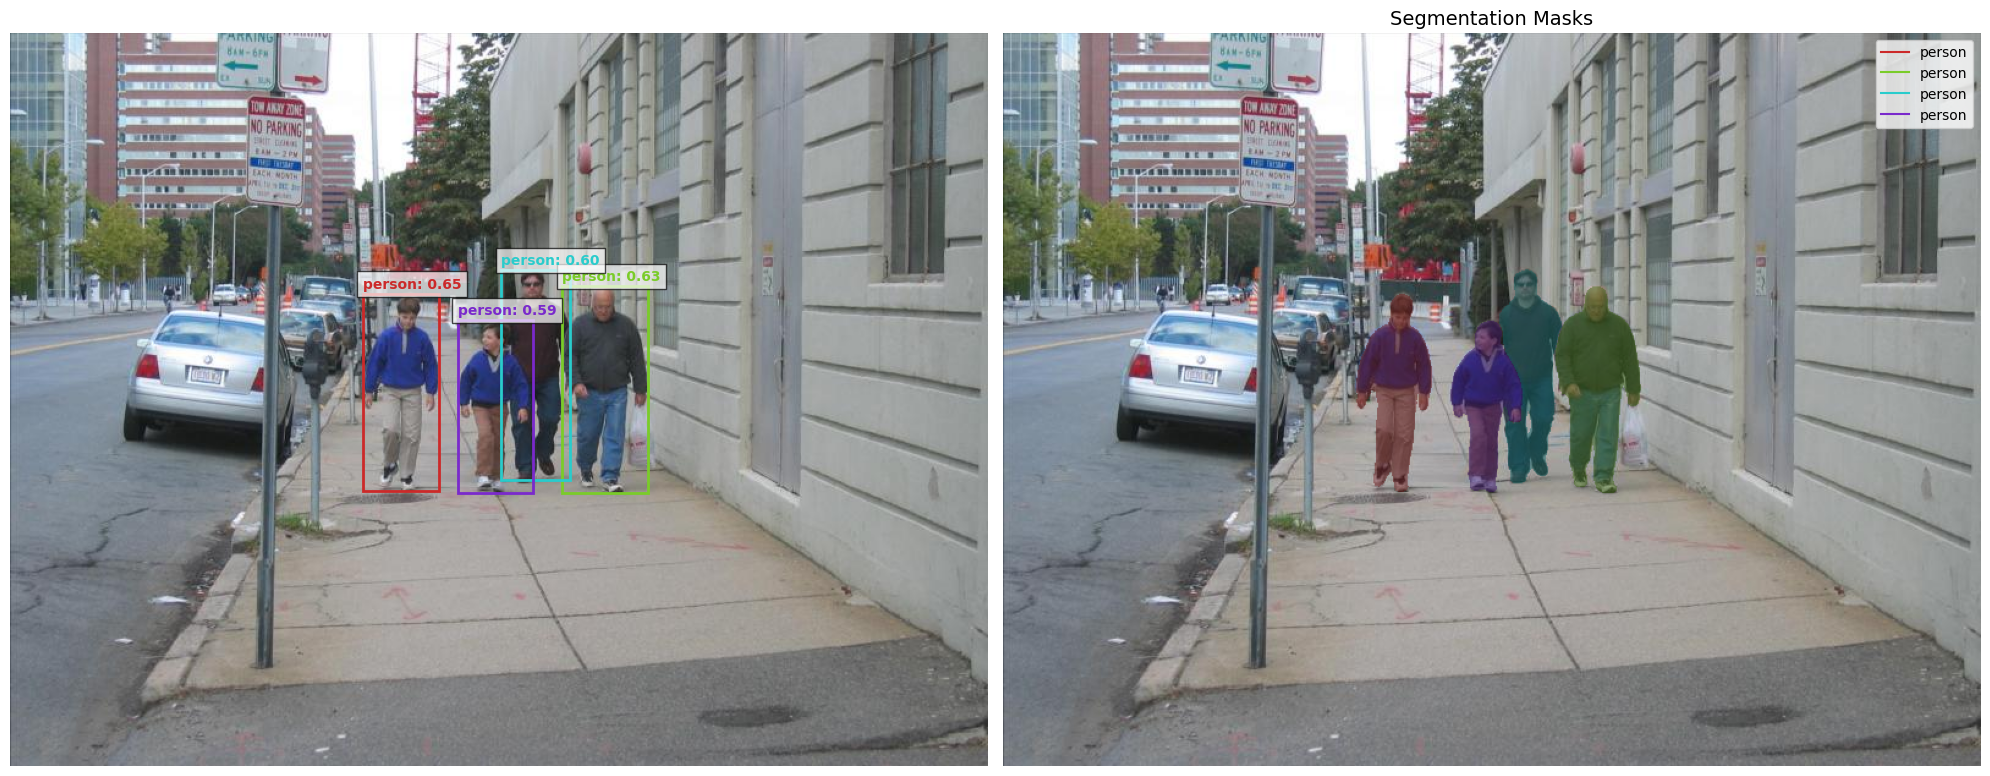

In [5]:
import torch
torch.mps.empty_cache()

image_path = '16.jpg'

print(os.path.abspath(image_path))
boxes, labels, confidences, masks = segmentation_model.segment(image_path=image_path)
outputs = segmentation_model.segment(image_path=image_path)

if outputs is None or any(x is None for x in outputs):
    raise ValueError("Segmentation model failed to return complete results.")
visualize_segmentation_results(image_path, boxes, labels, confidences, masks)

In [ ]:
api_key = ""

In [11]:
vlm = OpenAIModel(
    model_name='gpt-4o',
    # model_name='o3-2025-04-16',
    api_key=api_key
)
openai_embedding = OpenAIEmbeddings(
    model="text-embedding-3-small", 
    api_key=api_key
)

manipulator = BlackoutSegmentationManipulator(mask_type='bbox', preserve_overlapping=True)

In [12]:
# class SimpleSplitter:
#     def split(self, text: str):
#         return text.split()

#     def join(self, tokens):
#         return " ".join(tokens)

# splitter = SimpleSplitter()

splitter = StringSplitter()

# --- Create MultiModalSHAP analyzer ---
multimodal_shap = MultiModalSHAP(
    model=vlm,
    splitter=splitter,
    segmentation_model=segmentation_model,
    manipulator=manipulator,
    vectorizer=openai_embedding,
    debug=True,
    temp_dir="example_temp"
)

In [13]:
# --- Analyze ---
results_df, shapley_values = multimodal_shap.analyze(
    image_path=image_path,
    prompt=(
        "What color jacket is the man in the sunglasses wearing?"
    ),
    sampling_ratio=0.5,
    max_combinations=0,
    cleanup_temp_files=False
)

multimodal_shap.print_baseline()

Starting MultiModalSHAP analyze()
Image: 16.jpg
Prompt: What color jacket is the man in the sunglasses wearing?
Detected image objects:
  0: person
  1: person
  2: person
  3: person
_get_samples -> tokens: 10, objects: 4, total: 14
Total samples: 14
max_combinations (0) < essential combos (14); using all essential combos.
Essential combos: 14, Additional to sample: 0


Processing combinations:   0%|          | 0/14 [00:00<?, ?it/s]


_prepare_combination_args:
  prompt (len words): 9 -> 'color jacket is the man in the sunglasses wearing?'
  image_path: example_temp/temp_combo_0,1,2,3.jpg


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



_prepare_combination_args:
  prompt (len words): 9 -> 'What jacket is the man in the sunglasses wearing?'
  image_path: example_temp/temp_combo_0,1,2,3.jpg

_prepare_combination_args:
  prompt (len words): 9 -> 'What color is the man in the sunglasses wearing?'
  image_path: example_temp/temp_combo_0,1,2,3.jpg

_prepare_combination_args:
  prompt (len words): 9 -> 'What color jacket the man in the sunglasses wearing?'
  image_path: example_temp/temp_combo_0,1,2,3.jpg

_prepare_combination_args:
  prompt (len words): 9 -> 'What color jacket is man in the sunglasses wearing?'
  image_path: example_temp/temp_combo_0,1,2,3.jpg

_prepare_combination_args:
  prompt (len words): 9 -> 'What color jacket is the in the sunglasses wearing?'
  image_path: example_temp/temp_combo_0,1,2,3.jpg

_prepare_combination_args:
  prompt (len words): 9 -> 'What color jacket is the man the sunglasses wearing?'
  image_path: example_temp/temp_combo_0,1,2,3.jpg

_prepare_combination_args:
  prompt (len words):

Built DataFrame with 14 rows; sample similarities head:
                        Combination_Key  Similarity
0  combo_2,3,4,5,6,7,8,9,10,11,12,13,14    0.792495
1  combo_1,3,4,5,6,7,8,9,10,11,12,13,14    0.931048
2  combo_1,2,4,5,6,7,8,9,10,11,12,13,14    0.794168
3  combo_1,2,3,5,6,7,8,9,10,11,12,13,14    0.859004
4  combo_1,2,3,4,6,7,8,9,10,11,12,13,14    0.903122
Detected image objects:
  0: person
  1: person
  2: person
  3: person
_get_samples -> tokens: 10, objects: 4, total: 14

===== BASELINE TEXT RESPONSE =====

The man in the sunglasses is wearing a dark-colored jacket, possibly black or very dark brown.




In [14]:
results_df.head(32)

,Combination_Key,Used_Combination,Hidden_Samples,Response,Indexes,Similarity
0,"combo_2,3,4,5,6,7,8,9,10,11,12,13,14","[color_T1, jacket_T2, is_T3, the_T4, man_T5, i...",[What_T0],The man in the sunglasses is wearing a dark pu...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)",0.792495
1,"combo_1,3,4,5,6,7,8,9,10,11,12,13,14","[What_T0, jacket_T2, is_T3, the_T4, man_T5, in...",[color_T1],The man in the sunglasses is wearing a dark-co...,"(1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)",0.931048
2,"combo_1,2,4,5,6,7,8,9,10,11,12,13,14","[What_T0, color_T1, is_T3, the_T4, man_T5, in_...",[jacket_T2],The man in the sunglasses is wearing a dark-co...,"(1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)",0.794168
3,"combo_1,2,3,5,6,7,8,9,10,11,12,13,14","[What_T0, color_T1, jacket_T2, the_T4, man_T5,...",[is_T3],The man in the sunglasses is wearing a dark ma...,"(1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)",0.859004
4,"combo_1,2,3,4,6,7,8,9,10,11,12,13,14","[What_T0, color_T1, jacket_T2, is_T3, man_T5, ...",[the_T4],The man in sunglasses is wearing a dark brown ...,"(1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14)",0.903122
5,"combo_1,2,3,4,5,7,8,9,10,11,12,13,14","[What_T0, color_T1, jacket_T2, is_T3, the_T4, ...",[man_T5],The person wearing sunglasses is dressed in a ...,"(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14)",0.827843
6,"combo_1,2,3,4,5,6,8,9,10,11,12,13,14","[What_T0, color_T1, jacket_T2, is_T3, the_T4, ...",[in_T6],The man wearing sunglasses is dressed in a dar...,"(1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14)",0.811911
7,"combo_1,2,3,4,5,6,7,9,10,11,12,13,14","[What_T0, color_T1, jacket_T2, is_T3, the_T4, ...",[the_T7],The man in sunglasses is wearing a maroon jacket.,"(1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14)",0.756106
8,"combo_1,2,3,4,5,6,7,8,10,11,12,13,14","[What_T0, color_T1, jacket_T2, is_T3, the_T4, ...",[sunglasses_T8],The man is wearing a dark-colored jacket.,"(1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14)",0.781987
9,"combo_1,2,3,4,5,6,7,8,9,11,12,13,14","[What_T0, color_T1, jacket_T2, is_T3, the_T4, ...",[wearing?_T9],The man in sunglasses is wearing a dark red or...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14)",0.833611


In [15]:
# sorted_items = multimodal_shap.plot_importance_ranking(thumbnail_size=10)

import pandas as pd
import numpy as np
import re

text_df, obj_df, combined_df = multimodal_shap.compute_combined_importance(top_k=10)


Top text features:
   type          feature             base  shap_value
7  text         the_T7_8         the_T7_8    0.123135
8  text  sunglasses_T8_9  sunglasses_T8_9    0.109531
0  text        What_T0_1        What_T0_1    0.104007
2  text      jacket_T2_3      jacket_T2_3    0.103128
6  text          in_T6_7          in_T6_7    0.093801
5  text         man_T5_6         man_T5_6    0.085426
9  text   wearing?_T9_10   wearing?_T9_10    0.082394
3  text          is_T3_4          is_T3_4    0.069046
4  text         the_T4_5         the_T4_5    0.045855
1  text       color_T1_2       color_T1_2    0.031176

Top object features:
     type       feature          base  shap_value
2  object  person_O2_13  person_O2_13    0.082342
3  object  person_O3_14  person_O3_14    0.038984
1  object  person_O1_12  person_O1_12    0.031176
0  object  person_O0_11  person_O0_11    0.000000

Top combined text-object pairs:
         text_token  object_label  combined_importance
30         the_T7_8  perso

In [18]:
refined_df, refined_shap = multimodal_shap.rerun_with_top_features(
    top_k_text=3,
    top_k_objects=3,
    max_combinations=63  
)


[Stage-2] Selecting top features from prior SHAP...

Top text tokens (masking candidates): ['the_T7_8', 'sunglasses_T8_9', 'What_T0_1']
Top objects (masking candidates): ['person_O2_13', 'person_O3_14', 'person_O1_12']

Fixed tokens (always present): ['What', 'color', 'jacket', 'is', 'the', 'man', 'in', 'the', 'sunglasses', 'wearing?']

[Stage-2] Running exact SHAP with masked tokens + objects...

Total samples: 6
Essential combos: 6, Additional to sample: 57


Processing combinations:   0%|          | 0/63 [00:00<?, ?it/s]


_prepare_combination_args DEBUG
  Combination: ['sunglasses_T8_9', 'What_T0_1', 'person_O2_13', 'person_O3_14', 'person_O1_12']
  Masked tokens: {'What', 'sunglasses'}
  Final prompt (len=8): 'color jacket is the man in the wearing?'
  Keep objects: [1, 2, 3]
  Image path: example_temp/temp_combo_1_2_3.jpg
------------------------------------------------------------

_prepare_combination_args DEBUG
  Combination: ['the_T7_8', 'What_T0_1', 'person_O2_13', 'person_O3_14', 'person_O1_12']
  Masked tokens: {'What', 'the'}
  Final prompt (len=7): 'color jacket is man in sunglasses wearing?'
  Keep objects: [1, 2, 3]
  Image path: example_temp/temp_combo_1_2_3.jpg
------------------------------------------------------------

_prepare_combination_args DEBUG
  Combination: ['the_T7_8', 'sunglasses_T8_9', 'person_O2_13', 'person_O3_14', 'person_O1_12']
  Masked tokens: {'sunglasses', 'the'}
  Final prompt (len=7): 'What color jacket is man in wearing?'
  Keep objects: [1, 2, 3]
  Image path: e

In [19]:
import pandas as pd
import re

# Convert refined SHAP results into DataFrame
importance_df = pd.DataFrame([
    {"feature": k, "shap_value": v}
    for k, v in refined_shap.items()
])

# Determine modality based on suffix
importance_df["modality"] = importance_df["feature"].apply(
    lambda f: "object" if "_O" in f else "text" if "_T" in f else "unknown"
)

# Clean feature name: remove _T0, _O1, etc
importance_df["element"] = importance_df["feature"].str.replace(r"_[OT]\d+$", "", regex=True)

# Sort by SHAP magnitude (more meaningful)
importance_df = importance_df.reindex(
    importance_df["shap_value"].abs().sort_values(ascending=False).index
).reset_index(drop=True)

# Split into separate tables
image_importance = importance_df[importance_df["modality"] == "object"]
text_importance  = importance_df[importance_df["modality"] == "text"]

# Print results
print("\n===== REFINED TOP OBJECT FEATURES =====\n")
print(image_importance[["element", "shap_value"]].head(10), "\n")

print("\n===== REFINED TOP TEXT FEATURES =====\n")
print(text_importance[["element", "shap_value"]].head(10), "\n")

# Save
importance_df.to_csv("refined_multimodal_importance.csv", index=False)
image_importance.to_csv("refined_object_importance.csv", index=False)
text_importance.to_csv("refined_text_importance.csv", index=False)

# --------- TOP TEXT × OBJECT COMBINATIONS ---------

# Safety check
if len(text_importance) == 0 or len(image_importance) == 0:
    print("\nNo bimodal features available for interaction ranking.")
else:
    pairs = []

    # compute interaction strength = geometric mean (stable + scale-invariant)
    for _, t in text_importance.iterrows():
        for _, o in image_importance.iterrows():
            interaction = (abs(t["shap_value"]) * abs(o["shap_value"])) ** 0.5
            pairs.append({
                "text_token": t["element"],
                "object_label": o["element"],
                "combined_value": interaction,
                "text_shap": t["shap_value"],
                "object_shap": o["shap_value"]
            })

    pairs_df = pd.DataFrame(pairs)
    pairs_df = pairs_df.sort_values("combined_value", ascending=False)

    print("\n===== TOP TEXT × OBJECT COMBINATIONS =====\n")
    print(pairs_df[[
        "text_token", "object_label",
        "combined_value", "text_shap", "object_shap"
    ]].head(3), "\n")

    # Save table
    pairs_df.to_csv("refined_interaction_pairs.csv", index=False)




===== REFINED TOP OBJECT FEATURES =====

          element  shap_value
0  person_O2_13_4    0.330842
1  person_O1_12_6    0.290871
3  person_O3_14_5    0.147359 


===== REFINED TOP TEXT FEATURES =====

             element  shap_value
2         the_T7_8_1    0.150126
4        What_T0_1_3    0.080803
5  sunglasses_T8_9_2    0.000000 


===== TOP TEXT × OBJECT COMBINATIONS =====

    text_token    object_label  combined_value  text_shap  object_shap
0   the_T7_8_1  person_O2_13_4        0.222863   0.150126     0.330842
1   the_T7_8_1  person_O1_12_6        0.208967   0.150126     0.290871
3  What_T0_1_3  person_O2_13_4        0.163502   0.080803     0.330842 



## 2. Using OpenAI API Models

We start by using OpenAI's API to analyze token contributions in different scenarios.

Now we can analyze the prompt:

In [48]:
# prompt4 = "What are the symptoms of COVID-19?"
# df_local = token_shap_local.analyze(prompt4, sampling_ratio=0.0, print_highlight_text=True)
# token_shap_local.print_colored_text()

In [49]:
# df_local

In [50]:
# token_shap_local.highlight_text_background()

In [51]:
# token_shap_local.print_colored_text()

In [52]:
# token_shap_local.plot_colored_text()

In [53]:
# ollama_model = OllamaModel(model_name="llama3.2-vision:latest", api_url="http://35.95.163.15:11434")
# tfidf_embedding = TfidfTextVectorizer()
# token_shap_ollama = TokenSHAP(model=ollama_model, splitter=splitter, vectorizer=tfidf_embedding)

In [54]:
# prompt5 = "Explain quantum mechanics in simple terms."
# df_ollama = token_shap_ollama.analyze(prompt5, sampling_ratio=0.5, print_highlight_text=True)
# token_shap_ollama.print_colored_text()

Sentence-Level Splitting
For more advanced analysis, you might want to split the prompt into sentences rather than words. You can customized the splitter for this purpose.

In [ ]:
from token_shap import StringSplitter
from token_shap import TokenSHAP

api_key = ""
openai_model = OpenAIModel(api_key=api_key, model_name="gpt-4")
openai_embedding = OpenAIEmbeddings(api_key=api_key)
splitter = StringSplitter(split_pattern=r'\.')
token_shap_openai = TokenSHAP(model=openai_model, splitter=splitter, vectorizer=openai_embedding)

In [23]:
prompt = """Our company is experiencing a decline in quarterly sales for the first time in five years.
Recent market trends indicate increased competition from new startups offering similar products at lower prices.
Despite an increase in our online advertising budget, customer engagement on social media platforms has decreased by 15% compared to last quarter.
In addition, feedback from customer surveys suggests that many are dissatisfied with the lack of new features in our products.
Our largest competitor recently launched a new version of their product with innovative functionalities, which seems to have attracted a significant portion of our customer base.
What strategic actions should our company consider to regain market share and improve customer satisfaction?
"""

#### Output Explanation:

The analysis will consider each sentence as a token, allowing you to understand the importance of each sentence in generating the model's response.

In [24]:
splitter.split(prompt)

['Our company is experiencing a decline in quarterly sales for the first time in five years',
 '\nRecent market trends indicate increased competition from new startups offering similar products at lower prices',
 '\nDespite an increase in our online advertising budget, customer engagement on social media platforms has decreased by 15% compared to last quarter',
 '\nIn addition, feedback from customer surveys suggests that many are dissatisfied with the lack of new features in our products',
 '\nOur largest competitor recently launched a new version of their product with innovative functionalities, which seems to have attracted a significant portion of our customer base',
 '\nWhat strategic actions should our company consider to regain market share and improve customer satisfaction?']

In [25]:
df_sentence = token_shap_openai.analyze(prompt, sampling_ratio=0.5)

Processing combinations:   0%|          | 0/34 [00:00<?, ?it/s]

In [26]:
len(df_sentence)

34

In [27]:
df_sentence.head()

,Content,Response,Indexes,Similarity
0,Recent market trends indicate increased compe...,1. Product Innovation: The company should focu...,"(2, 3, 4, 5, 6)",0.913307
1,Our company is experiencing a decline in quart...,1. Product Innovation: Start by focusing on th...,"(1, 3, 4, 5, 6)",0.897109
2,Our company is experiencing a decline in quart...,1. Product Innovation: To attract customers ba...,"(1, 2, 4, 5, 6)",0.884416
3,Our company is experiencing a decline in quart...,1. Product Innovation: Consider investing in r...,"(1, 2, 3, 5, 6)",0.888905
4,Our company is experiencing a decline in quart...,1. Competitive Pricing: Consider revising your...,"(1, 2, 3, 4, 6)",0.918602


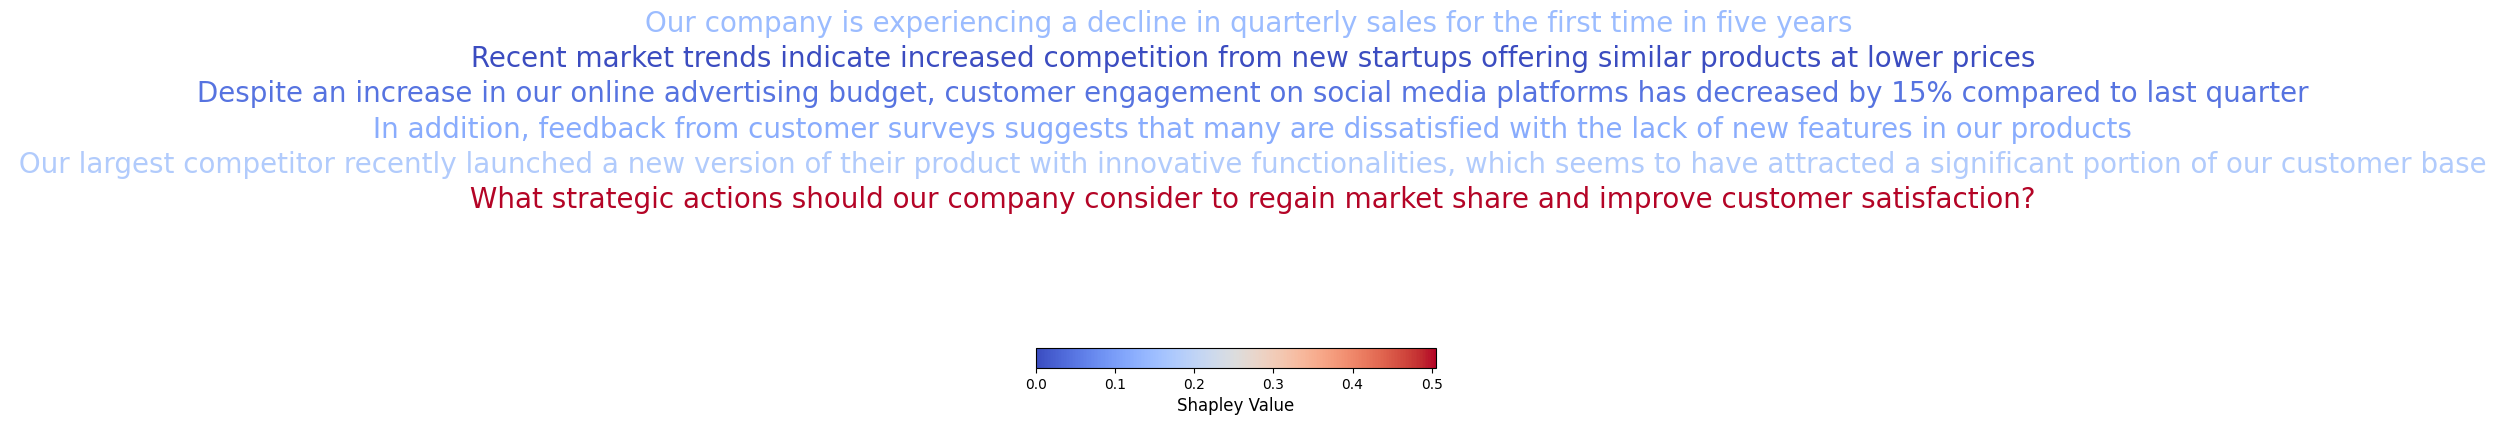

In [28]:
token_shap_openai.plot_colored_text(new_line = True)

In [29]:
token_shap_openai.print_colored_text()

Our company is experiencing a decline in quarterly sales for the first time in five years  Recent market trends indicate increased competition from new startups offering similar products at lower prices  Despite an increase in our online advertising budget, customer engagement on social media platforms has decreased by 15% compared to last quarter  In addition, feedback from customer surveys suggests that many are dissatisfied with the lack of new features in our products  Our largest competitor recently launched a new version of their product with innovative functionalities, which seems to have attracted a significant portion of our customer base  What strategic actions should our company consider to regain market share and improve customer satisfaction? 


In [30]:
token_shap_openai.highlight_text_background()

Our company is experiencing a decline in quarterly sales for the first time in five years  Recent market trends indicate increased competition from new startups offering similar products at lower prices  Despite an increase in our online advertising budget, customer engagement on social media platforms has decreased by 15% compared to last quarter  In addition, feedback from customer surveys suggests that many are dissatisfied with the lack of new features in our products  Our largest competitor recently launched a new version of their product with innovative functionalities, which seems to have attracted a significant portion of our customer base  What strategic actions should our company consider to regain market share and improve customer satisfaction? 
